Zoahr Yakovi

Matan Akrabi 


Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

# Initialize install and import packages and classes.

In [ ]:
# !pip install gym  torch
# !apt-get install python-opengl ffmpeg -y 
# !apt install xvfb -y 
# !pip install pyvirtualdisplay  
# !pip install piglet 
# !pip install gym[box2d] 
# !pip install tensorflow
# !pip install box2d
# !python -m pip install pyvirtualdisplay

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
def show_video():
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
class defaultActions:
    """
    class that define all available actions 
    
    """
    def __init__(self):

        self.main = [[1    , "Main strong"],
                     [0.51 ,"Main slow"],
#                      [0.75 , "Main meduim"],
                     [0 , "Main off"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
                        [-0.5 , "Left slow"],
#                         [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
                        [0.5 , "Right slow"],
#                         [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        """
        :param id: id of action 
        :return: return action and discription
        """
        return self.all_actions[id]

    def get_action(self,id,add_noise=False):
        """
        :param id: id of action 
        :param add_noise: add noise to the engains
        :return: engain vector
        """
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
        """
        :param id: id of action 
        :return: return discription
        """     
        return self.all_actions[id][1]

    def get_action_count(self):
        """ 
        :return: return actions count
        """
        return len(self.all_actions)
actions = defaultActions()

In [6]:

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):
        """
        Initialize parameters and build model.

        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        """        
        
        super(QNetwork, self).__init__()
        hidden_size = 30
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, action_size)
        

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action = self.out(x)
        return action
    
class DuelingQNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):

        """
        Initialize parameters and build model.

        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        """   
        
        super(DuelingQNetwork, self).__init__()
        self.num_actions = action_size
        fc3_1_size = fc3_2_size = 32
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        ## Here we separate into two streams
        # The one that calculate V(s)
        self.fc3_1 = nn.Linear(fc2_size, fc3_1_size)
        self.fc4_1 = nn.Linear(fc3_1_size, 1)
        # The one that calculate A(s,a)
        self.fc3_2 = nn.Linear(fc2_size, fc3_2_size)
        self.fc4_2 = nn.Linear(fc3_2_size, action_size)



    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_1(x))
        val = self.fc4_1(val)
        
        adv = F.relu(self.fc3_2(x))
        adv = self.fc4_2(adv)
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.num_actions)
        return action

In [7]:

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.0003772               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():

    def __init__(self, state_size, action_size, seed,lr=LR):
        
        """
        Initialize an Agent object.
        
        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        :param lr: learning rate
        """   
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr = lr

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn_DDQN(experiences, GAMMA)

    def act(self, state, eps=0.):
        
        """
        :param state: current state
        :param eps : epsilon, for epsilon-greedy action selection
        :param seed: Random seed 
        :return: actions for given state as per current policy.  
        """
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        
        """
        Update value parameters using given batch of experience tuples.

        :param state: experiences : tuple of (s, a, r, s', done) tuples 
        :param gamma: discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
        
       
    def learn_DDQN(self, experiences, gamma):
        
        """
        Update value parameters using given batch of experience tuples.

        :param state: experiences : tuple of (s, a, r, s', done) tuples 
        :param gamma: discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        # Get index of maximum value for next state from Q_expected
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        #print (self.qnetwork_local(states).detach())
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, a_prime.unsqueeze(1))
        #print (Q_targets_next.shape)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        #print (Q_targets.shape)
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        #print (Q_expected.shape)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

       
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  

    def soft_update(self, local_model, target_model, tau):
        
        """
        Soft update model parameters.

        :param local_model: weights will be copied from
        :param target_model : weights will be copied to
        :param tau : interpolation parameter 
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        
        """
        Initialize a ReplayBuffer object.

        :param action_size: dimension of each action
        :param buffer_size: maximum size of buffer
        :param batch_size: size of each training batch
        :param seed: random seed 
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [8]:

#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Train the Agent 

In [9]:
# env = gym.make('LunarLander-v2')
# env.seed(0)
env = gym.make('LunarLanderContinuous-v2')
env.seed(0)
env.reset()
np.random.seed(0)
print('State shape: ', env.observation_space.shape)
# print('Number of actions: ', env.action_space.n)

State shape:  (8,)


In [10]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    """
        Deep Q-Learning.

        :param n_episodes: maximum number of training episodes
        :param max_t: maximum number of timesteps per episode
        :param eps_start: starting value of epsilon, for epsilon-greedy action selection
        eps_end: minimum value of epsilon
        eps_decay: multiplicative factor (per episode) for decreasing epsilon
    """

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action_step = actions.get_action(action)
            next_state, reward, done, _ = env.step(action_step)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Dueling_DDQN.pth')
            break
    return scores


Episode 100	Average Score: -362.85
Episode 150	Average Score: -323.24Learning rate:0.00035


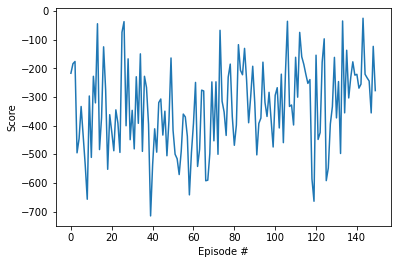

found better LR = 0.00035
Episode 100	Average Score: -330.45
Episode 150	Average Score: -253.71Learning rate:0.0003502


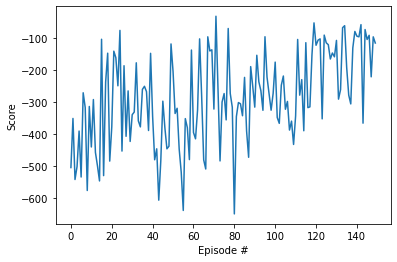

found better LR = 0.0003502
Episode 100	Average Score: -307.99
Episode 150	Average Score: -231.82Learning rate:0.0003504


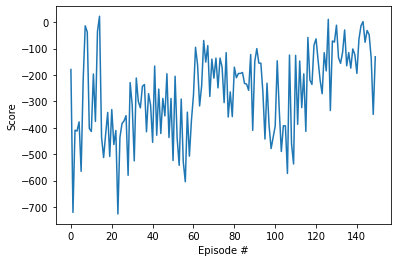

found better LR = 0.0003504
Episode 100	Average Score: -244.16
Episode 150	Average Score: -148.74Learning rate:0.0003506


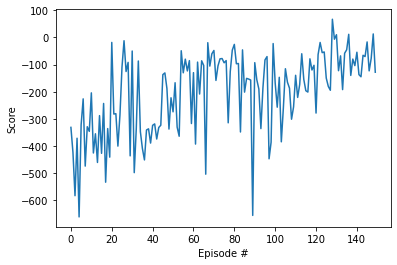

found better LR = 0.0003506
Episode 100	Average Score: -350.93
Episode 150	Average Score: -219.59Learning rate:0.0003508


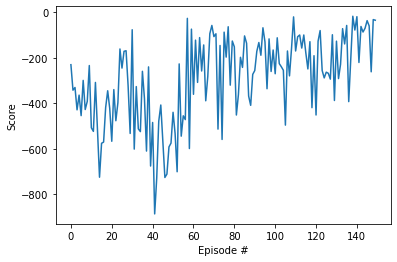

Episode 100	Average Score: -308.70
Episode 150	Average Score: -325.65Learning rate:0.000351


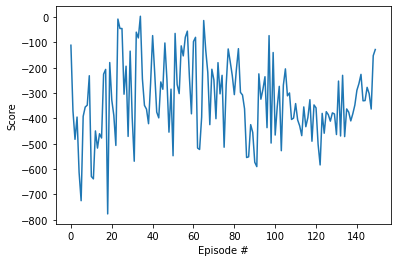

Episode 100	Average Score: -339.53
Episode 150	Average Score: -280.63Learning rate:0.0003512


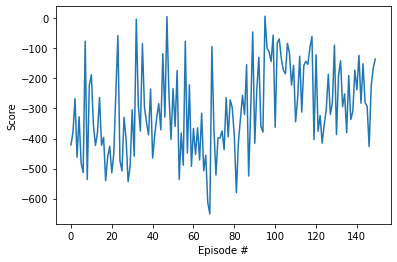

Episode 100	Average Score: -305.72
Episode 150	Average Score: -292.98Learning rate:0.00035140000000000003


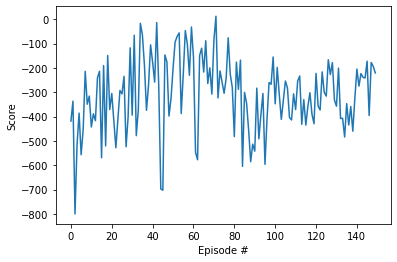

Episode 100	Average Score: -294.37
Episode 150	Average Score: -170.43Learning rate:0.00035160000000000004


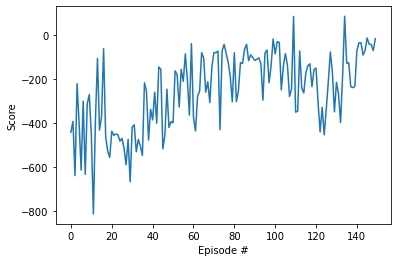

found better LR = 0.00035160000000000004
Episode 100	Average Score: -260.41
Episode 150	Average Score: -204.24Learning rate:0.00035180000000000004


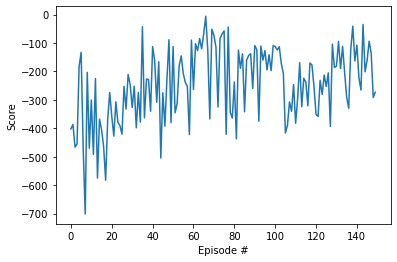

Episode 100	Average Score: -322.44
Episode 150	Average Score: -261.52Learning rate:0.00035200000000000005


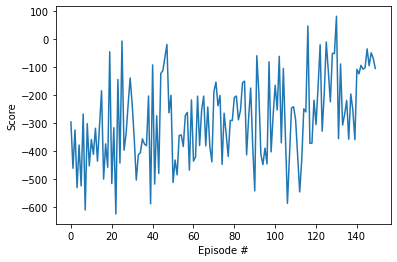

Episode 100	Average Score: -306.69
Episode 150	Average Score: -337.61Learning rate:0.00035220000000000005


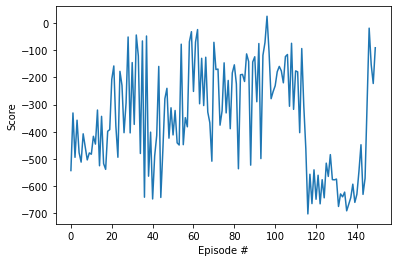

Episode 100	Average Score: -264.31
Episode 150	Average Score: -165.99Learning rate:0.00035240000000000005


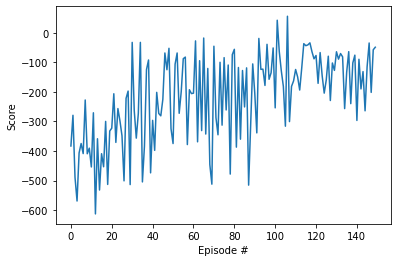

Episode 100	Average Score: -348.77
Episode 150	Average Score: -346.17Learning rate:0.00035260000000000006


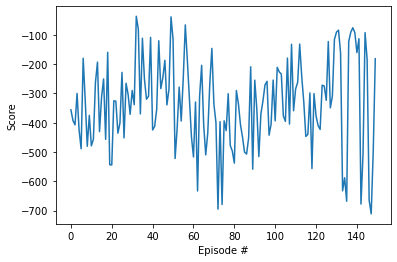

Episode 100	Average Score: -355.09
Episode 150	Average Score: -338.37Learning rate:0.00035280000000000006


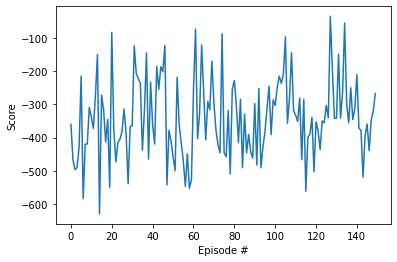

Episode 100	Average Score: -258.67
Episode 150	Average Score: -219.24Learning rate:0.00035300000000000007


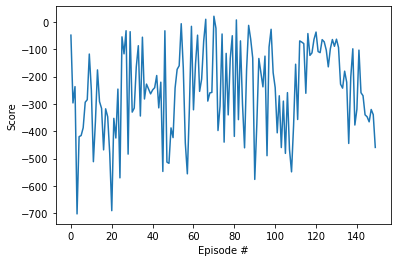

Episode 100	Average Score: -308.01
Episode 150	Average Score: -196.91Learning rate:0.0003532000000000001


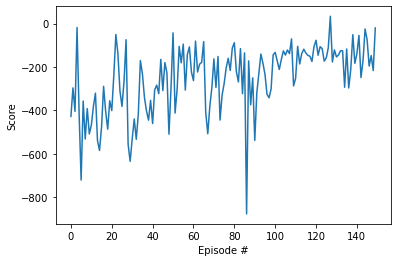

Episode 100	Average Score: -324.86
Episode 150	Average Score: -255.79Learning rate:0.0003534000000000001


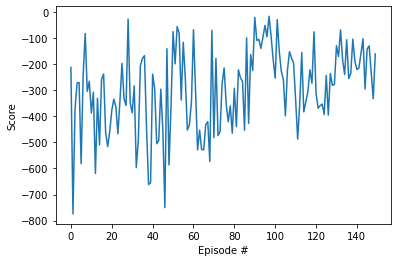

Episode 100	Average Score: -315.80
Episode 150	Average Score: -172.58Learning rate:0.0003536000000000001


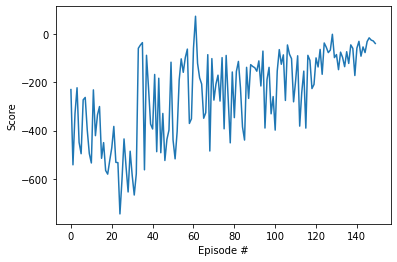

found better LR = 0.0003536000000000001
Episode 100	Average Score: -330.64
Episode 150	Average Score: -264.46Learning rate:0.0003538000000000001


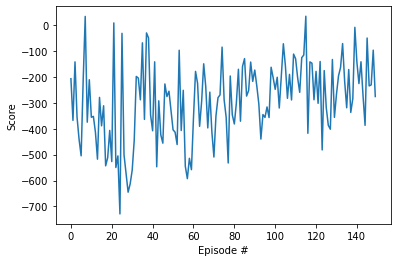

Episode 100	Average Score: -380.99
Episode 150	Average Score: -281.44Learning rate:0.0003540000000000001


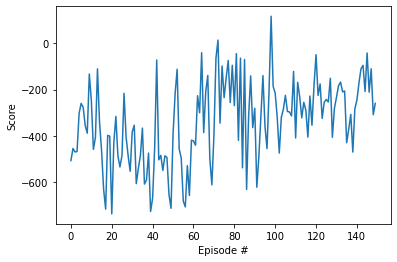

Episode 100	Average Score: -229.45
Episode 150	Average Score: -131.99Learning rate:0.0003542000000000001


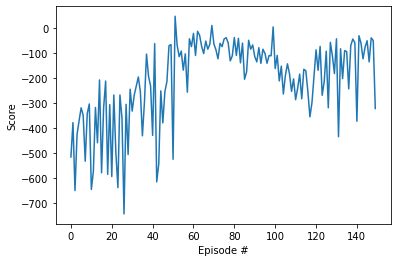

Episode 100	Average Score: -287.69
Episode 150	Average Score: -262.15Learning rate:0.0003544000000000001


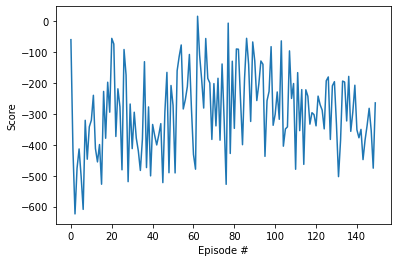

Episode 100	Average Score: -301.68
Episode 150	Average Score: -293.34Learning rate:0.0003546000000000001


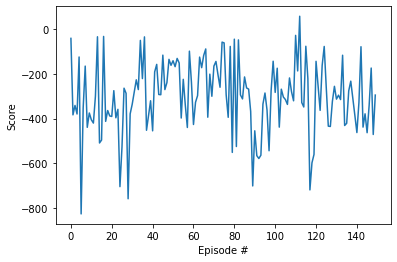

Episode 100	Average Score: -332.23
Episode 150	Average Score: -252.94Learning rate:0.0003548000000000001


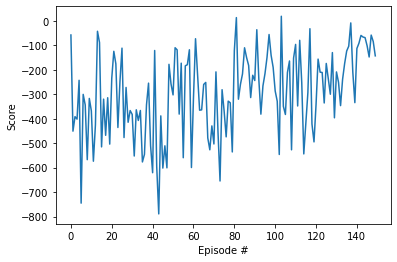

Episode 100	Average Score: -311.55
Episode 150	Average Score: -317.47Learning rate:0.0003550000000000001


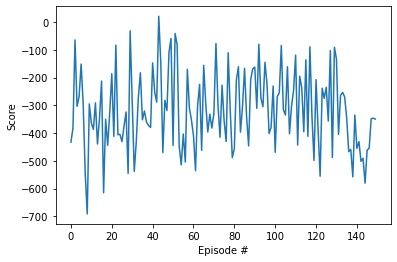

Episode 100	Average Score: -292.80
Episode 150	Average Score: -214.55Learning rate:0.0003552000000000001


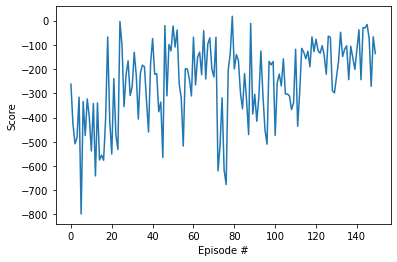

Episode 100	Average Score: -291.66
Episode 150	Average Score: -212.04Learning rate:0.00035540000000000013


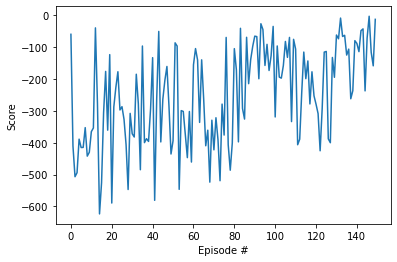

Episode 100	Average Score: -275.98
Episode 150	Average Score: -263.44Learning rate:0.00035560000000000013


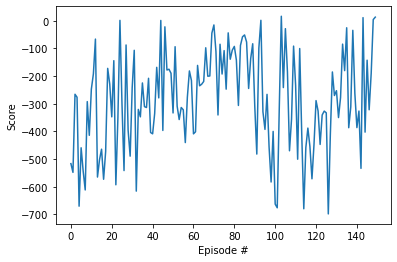

Episode 100	Average Score: -331.89
Episode 150	Average Score: -239.53Learning rate:0.00035580000000000014


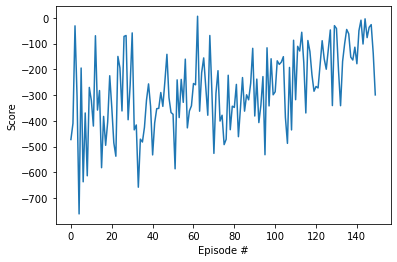

Episode 100	Average Score: -326.31
Episode 150	Average Score: -297.22Learning rate:0.00035600000000000014


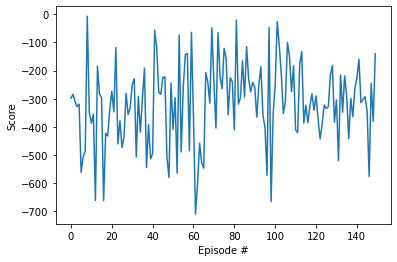

Episode 100	Average Score: -276.36
Episode 150	Average Score: -265.72Learning rate:0.00035620000000000015


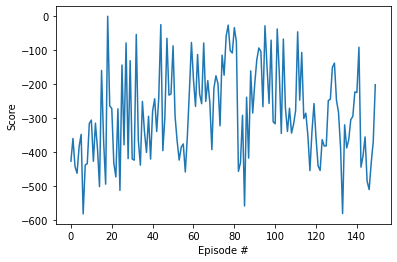

Episode 100	Average Score: -332.95
Episode 150	Average Score: -262.12Learning rate:0.00035640000000000015


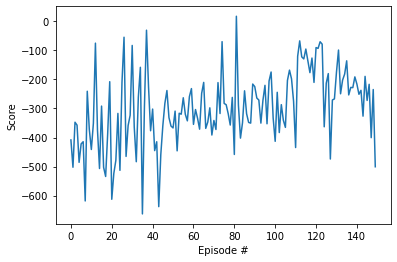

Episode 100	Average Score: -315.84
Episode 150	Average Score: -256.99Learning rate:0.00035660000000000016


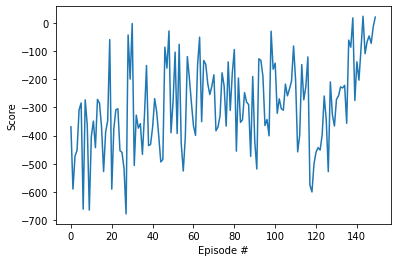

Episode 100	Average Score: -350.90
Episode 150	Average Score: -294.72Learning rate:0.00035680000000000016


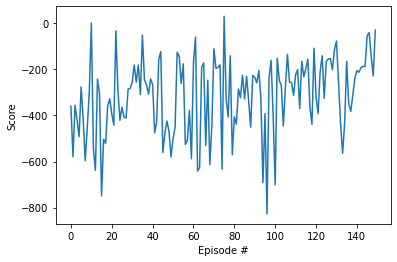

Episode 100	Average Score: -364.87
Episode 150	Average Score: -340.70Learning rate:0.00035700000000000017


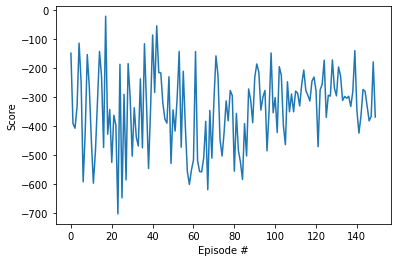

Episode 100	Average Score: -308.60
Episode 150	Average Score: -317.61Learning rate:0.00035720000000000017


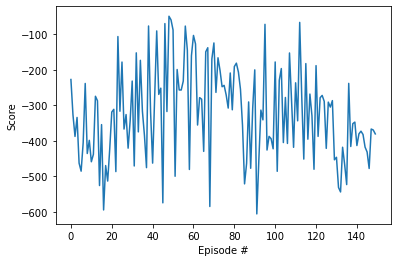

Episode 100	Average Score: -294.38
Episode 150	Average Score: -162.10Learning rate:0.0003574000000000002


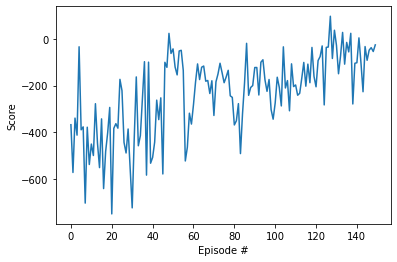

Episode 100	Average Score: -272.99
Episode 150	Average Score: -277.40Learning rate:0.0003576000000000002


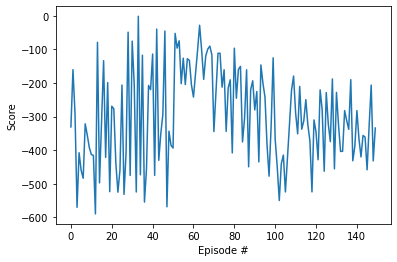

Episode 100	Average Score: -351.63
Episode 150	Average Score: -282.52Learning rate:0.0003578000000000002


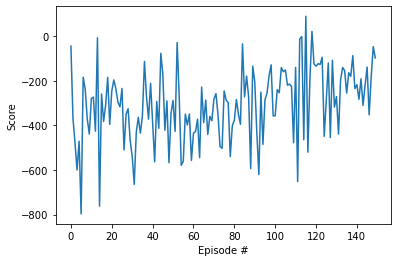

Episode 100	Average Score: -258.50
Episode 150	Average Score: -272.77Learning rate:0.0003580000000000002


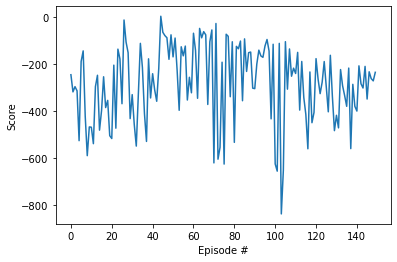

Episode 100	Average Score: -298.39
Episode 150	Average Score: -160.87Learning rate:0.0003582000000000002


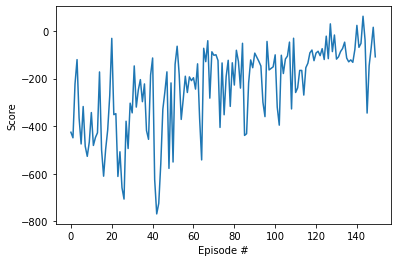

Episode 100	Average Score: -315.02
Episode 150	Average Score: -240.15Learning rate:0.0003584000000000002


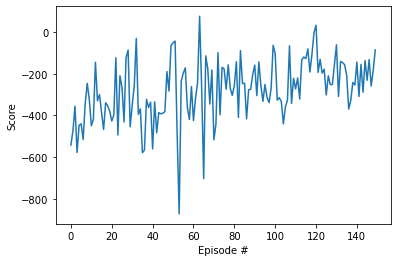

Episode 100	Average Score: -304.74
Episode 150	Average Score: -280.42Learning rate:0.0003586000000000002


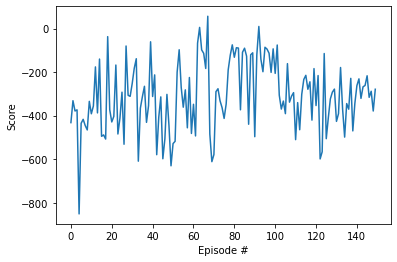

Episode 100	Average Score: -300.33
Episode 150	Average Score: -222.81Learning rate:0.0003588000000000002


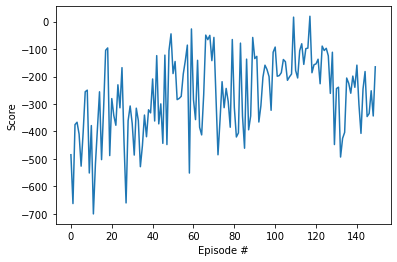

Episode 100	Average Score: -325.73
Episode 150	Average Score: -290.72Learning rate:0.0003590000000000002


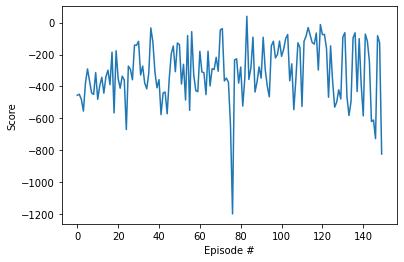

Episode 100	Average Score: -224.21
Episode 150	Average Score: -136.42Learning rate:0.0003592000000000002


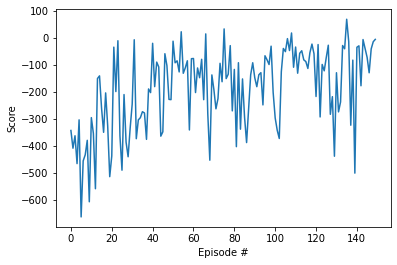

Episode 100	Average Score: -329.05
Episode 150	Average Score: -231.51Learning rate:0.0003594000000000002


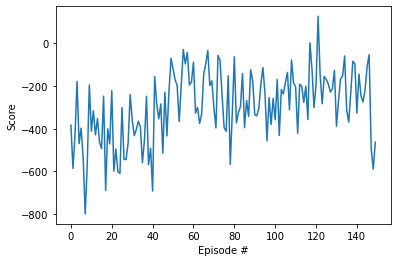

Episode 100	Average Score: -333.41
Episode 150	Average Score: -269.07Learning rate:0.00035960000000000023


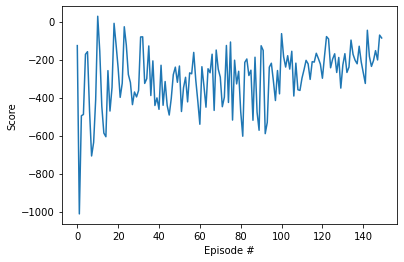

Episode 100	Average Score: -292.40
Episode 150	Average Score: -245.21Learning rate:0.00035980000000000023


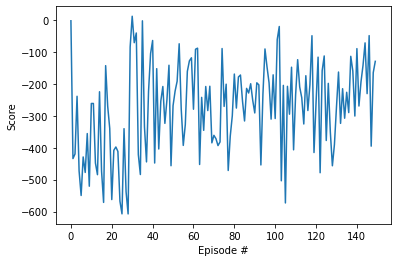

Episode 100	Average Score: -316.46
Episode 150	Average Score: -217.81Learning rate:0.00036000000000000024


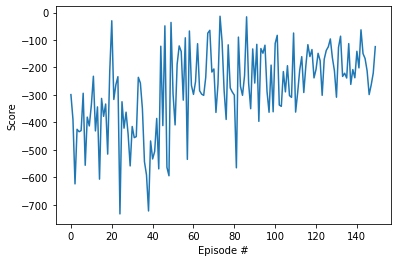

Episode 100	Average Score: -294.96
Episode 150	Average Score: -219.94Learning rate:0.00036020000000000024


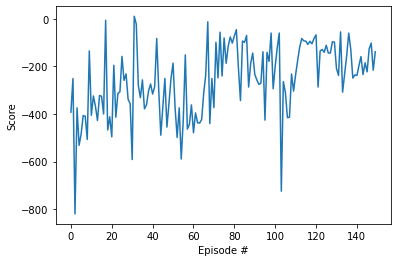

Episode 100	Average Score: -300.90
Episode 150	Average Score: -252.94Learning rate:0.00036040000000000025


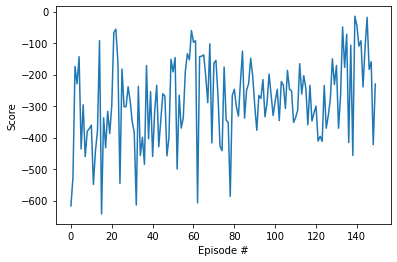

Episode 100	Average Score: -265.86
Episode 150	Average Score: -144.35Learning rate:0.00036060000000000025


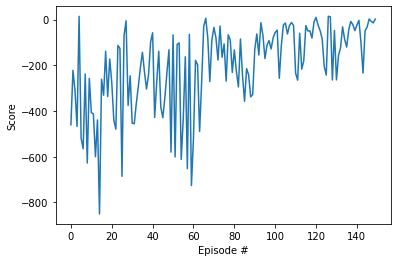

Episode 100	Average Score: -299.70
Episode 150	Average Score: -224.35Learning rate:0.00036080000000000026


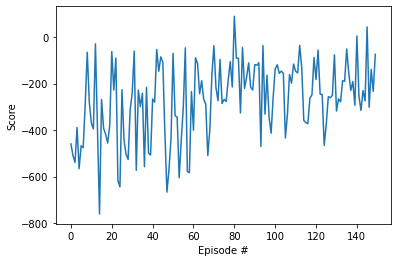

Episode 100	Average Score: -276.03
Episode 150	Average Score: -202.05Learning rate:0.00036100000000000026


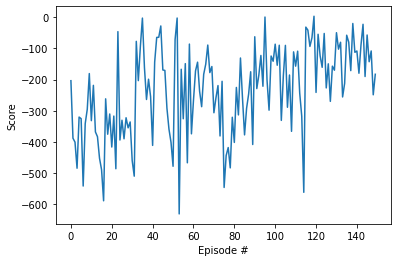

Episode 100	Average Score: -355.76
Episode 150	Average Score: -353.72Learning rate:0.00036120000000000027


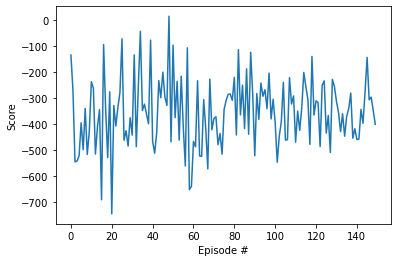

Episode 100	Average Score: -330.33
Episode 150	Average Score: -292.19Learning rate:0.0003614000000000003


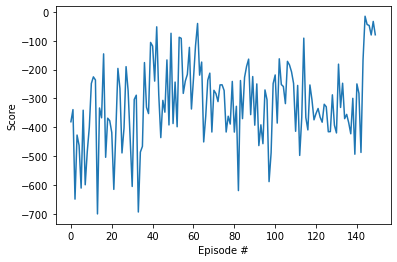

Episode 100	Average Score: -342.86
Episode 150	Average Score: -255.72Learning rate:0.0003616000000000003


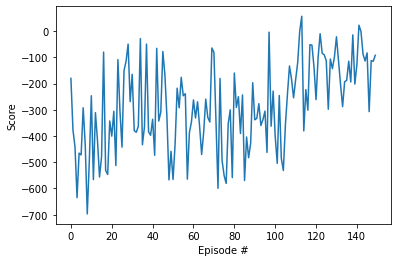

Episode 100	Average Score: -343.38
Episode 150	Average Score: -284.99Learning rate:0.0003618000000000003


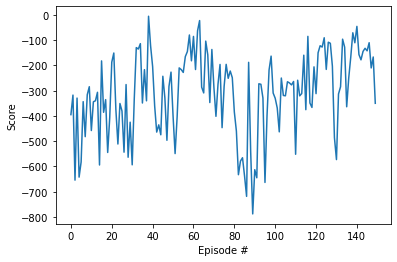

Episode 100	Average Score: -324.56
Episode 150	Average Score: -323.18Learning rate:0.0003620000000000003


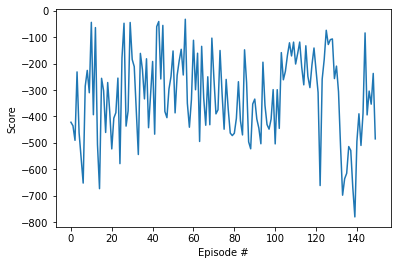

Episode 100	Average Score: -284.35
Episode 150	Average Score: -204.93Learning rate:0.0003622000000000003


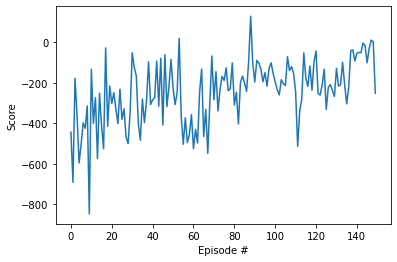

Episode 100	Average Score: -294.59
Episode 150	Average Score: -237.46Learning rate:0.0003624000000000003


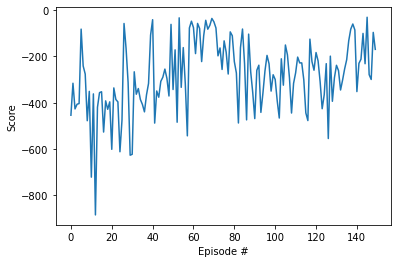

Episode 100	Average Score: -352.96
Episode 150	Average Score: -338.51Learning rate:0.0003626000000000003


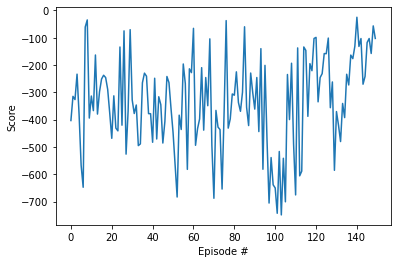

Episode 100	Average Score: -315.86
Episode 150	Average Score: -258.49Learning rate:0.0003628000000000003


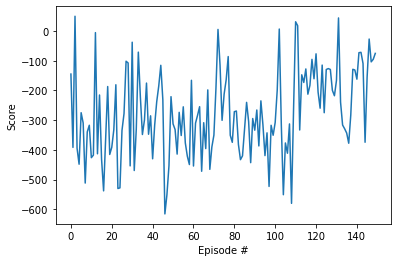

Episode 100	Average Score: -402.70
Episode 150	Average Score: -294.04Learning rate:0.0003630000000000003


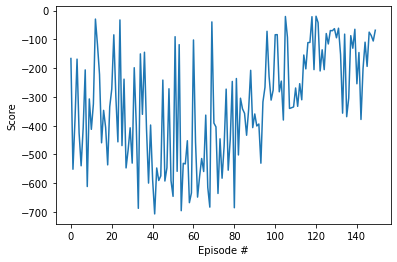

Episode 100	Average Score: -299.21
Episode 150	Average Score: -167.13Learning rate:0.0003632000000000003


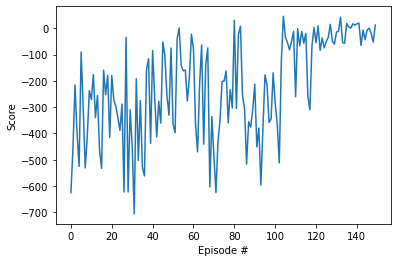

found better LR = 0.0003632000000000003
Episode 100	Average Score: -300.65
Episode 150	Average Score: -226.99Learning rate:0.0003634000000000003


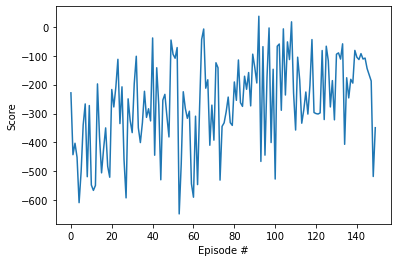

Episode 100	Average Score: -376.17
Episode 150	Average Score: -354.39Learning rate:0.0003636000000000003


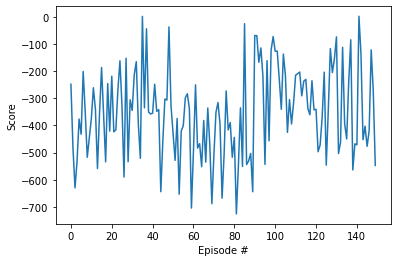

Episode 100	Average Score: -294.26
Episode 150	Average Score: -207.04Learning rate:0.00036380000000000033


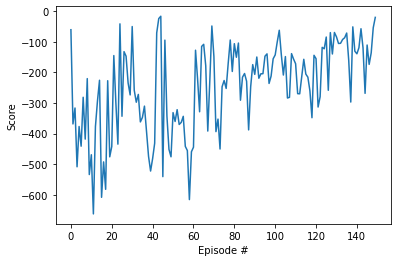

Episode 100	Average Score: -309.75
Episode 150	Average Score: -349.87Learning rate:0.00036400000000000034


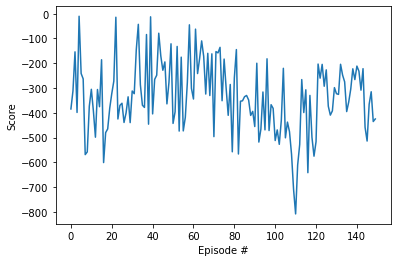

Episode 100	Average Score: -329.08
Episode 150	Average Score: -286.29Learning rate:0.00036420000000000034


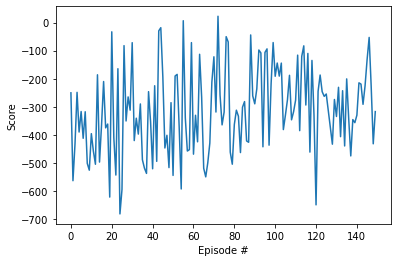

Episode 100	Average Score: -353.95
Episode 150	Average Score: -252.13Learning rate:0.00036440000000000035


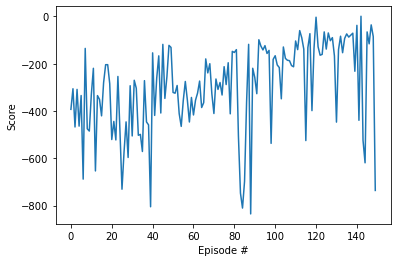

Episode 100	Average Score: -335.40
Episode 150	Average Score: -318.89Learning rate:0.00036460000000000035


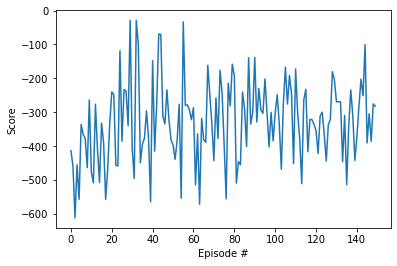

Episode 100	Average Score: -329.36
Episode 150	Average Score: -364.24Learning rate:0.00036480000000000036


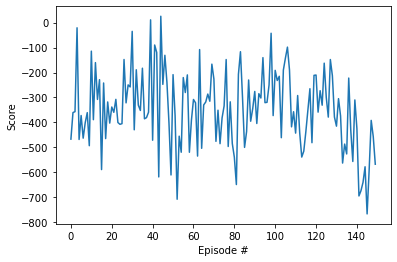

Episode 100	Average Score: -327.61
Episode 150	Average Score: -283.81Learning rate:0.00036500000000000036


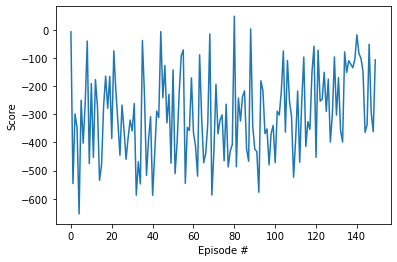

Episode 100	Average Score: -331.30
Episode 150	Average Score: -283.13Learning rate:0.00036520000000000037


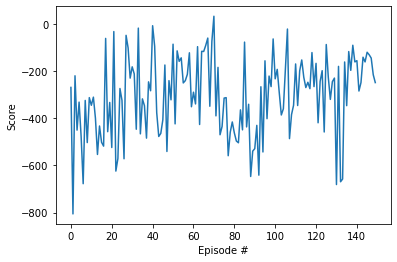

Episode 100	Average Score: -318.93
Episode 150	Average Score: -264.16Learning rate:0.00036540000000000037


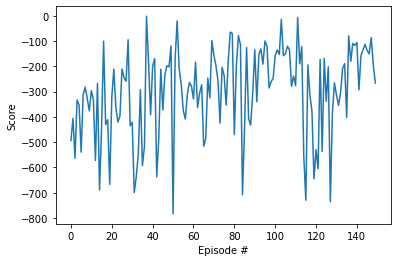

Episode 100	Average Score: -346.98
Episode 150	Average Score: -286.99Learning rate:0.0003656000000000004


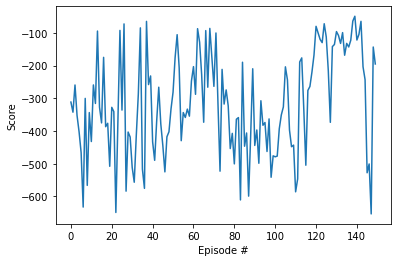

Episode 100	Average Score: -308.56
Episode 150	Average Score: -237.97Learning rate:0.0003658000000000004


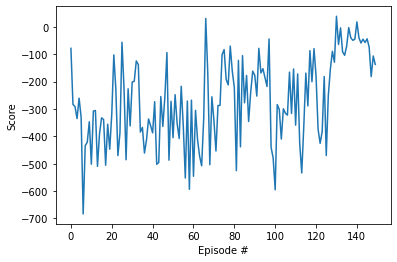

Episode 100	Average Score: -304.27
Episode 150	Average Score: -210.26Learning rate:0.0003660000000000004


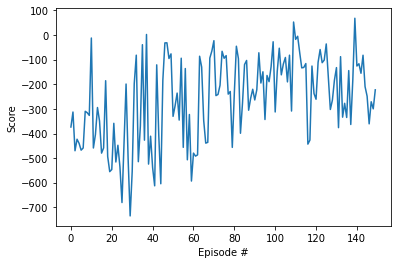

Episode 100	Average Score: -338.19
Episode 150	Average Score: -302.29Learning rate:0.0003662000000000004


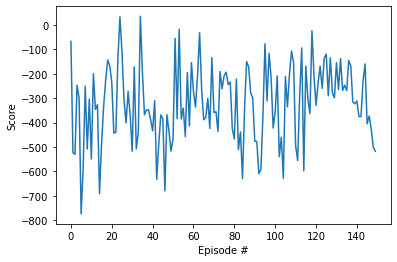

Episode 100	Average Score: -311.72
Episode 150	Average Score: -251.80Learning rate:0.0003664000000000004


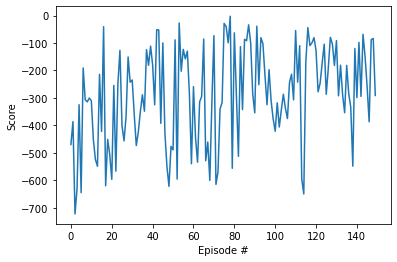

Episode 100	Average Score: -348.45
Episode 150	Average Score: -307.28Learning rate:0.0003666000000000004


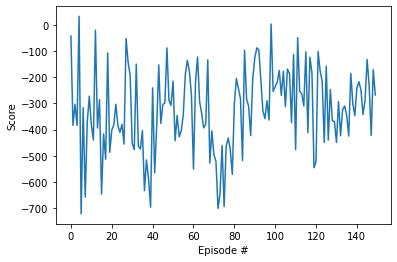

Episode 100	Average Score: -319.15
Episode 150	Average Score: -198.71Learning rate:0.0003668000000000004


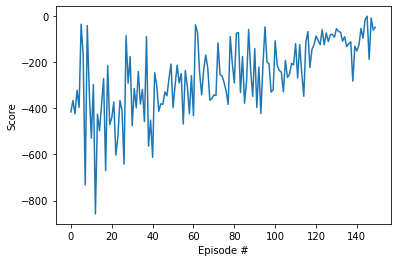

Episode 100	Average Score: -312.83
Episode 150	Average Score: -238.65Learning rate:0.0003670000000000004


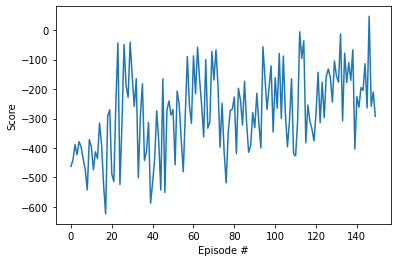

Episode 100	Average Score: -307.83
Episode 150	Average Score: -246.38Learning rate:0.0003672000000000004


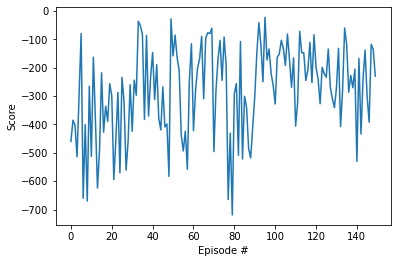

Episode 100	Average Score: -387.38
Episode 150	Average Score: -337.71Learning rate:0.0003674000000000004


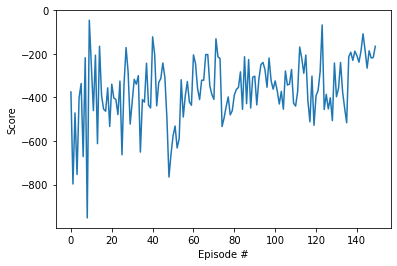

Episode 100	Average Score: -286.49
Episode 150	Average Score: -193.39Learning rate:0.0003676000000000004


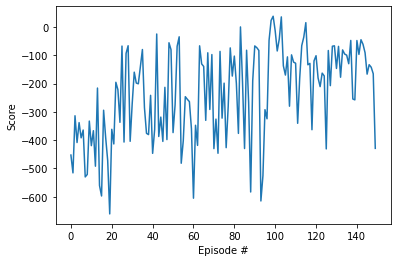

Episode 100	Average Score: -294.10
Episode 150	Average Score: -258.06Learning rate:0.00036780000000000043


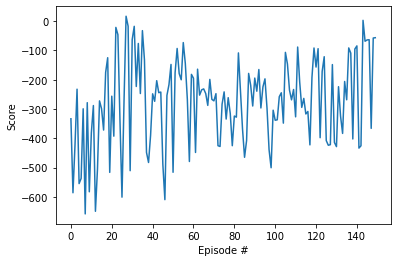

Episode 100	Average Score: -284.00
Episode 150	Average Score: -191.82Learning rate:0.00036800000000000043


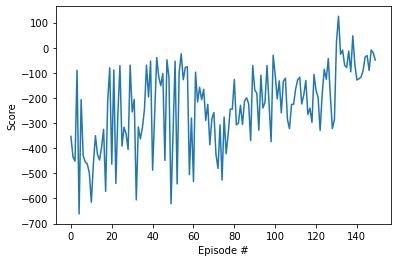

Episode 100	Average Score: -312.50
Episode 150	Average Score: -303.47Learning rate:0.00036820000000000044


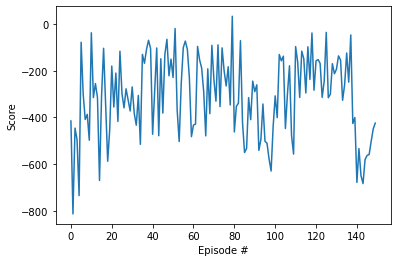

Episode 100	Average Score: -329.90
Episode 150	Average Score: -349.28Learning rate:0.00036840000000000044


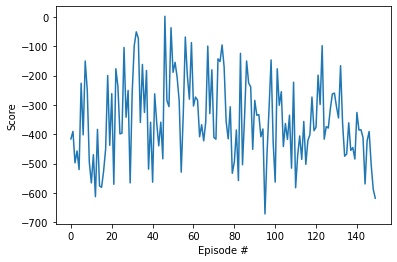

Episode 100	Average Score: -314.11
Episode 150	Average Score: -301.64Learning rate:0.00036860000000000045


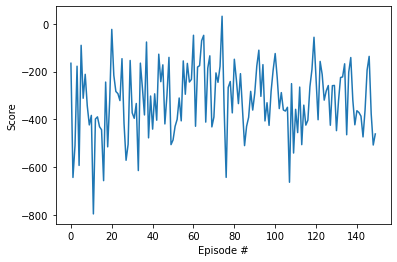

Episode 100	Average Score: -309.07
Episode 150	Average Score: -265.41Learning rate:0.00036880000000000045


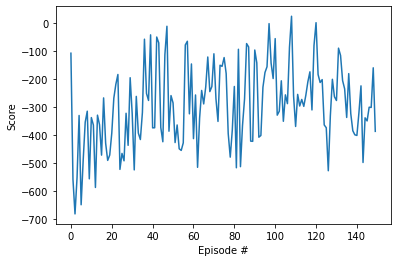

Episode 100	Average Score: -325.79
Episode 150	Average Score: -337.27Learning rate:0.00036900000000000046


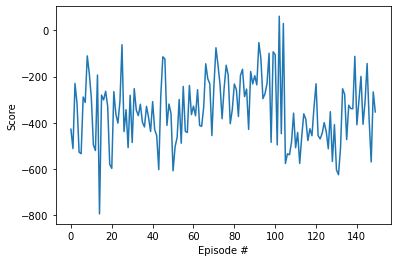

Episode 100	Average Score: -259.15
Episode 150	Average Score: -205.88Learning rate:0.00036920000000000046


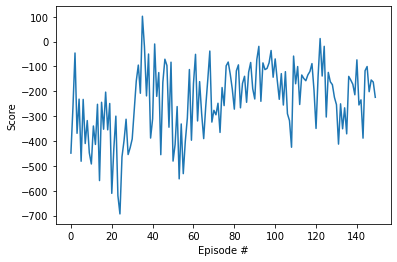

Episode 100	Average Score: -327.06
Episode 150	Average Score: -281.13Learning rate:0.00036940000000000047


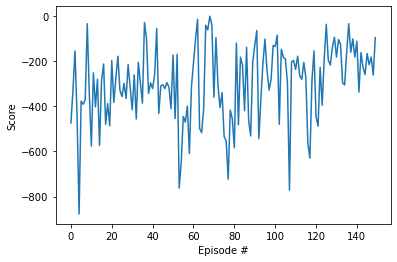

Episode 100	Average Score: -310.66
Episode 150	Average Score: -279.80Learning rate:0.00036960000000000047


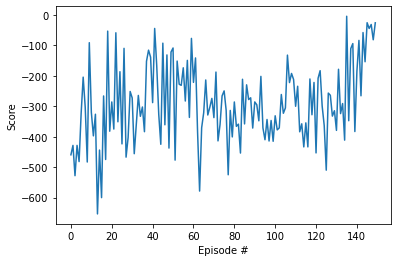

Episode 100	Average Score: -341.58
Episode 150	Average Score: -278.24Learning rate:0.0003698000000000005


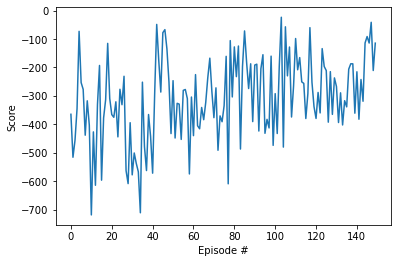

Episode 100	Average Score: -314.52
Episode 150	Average Score: -315.27Learning rate:0.0003700000000000005


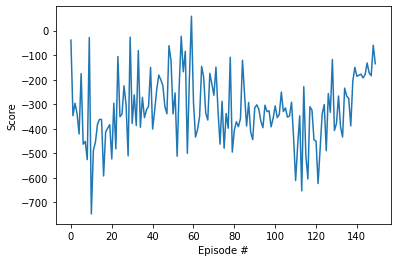

Episode 100	Average Score: -342.23
Episode 150	Average Score: -230.01Learning rate:0.0003702000000000005


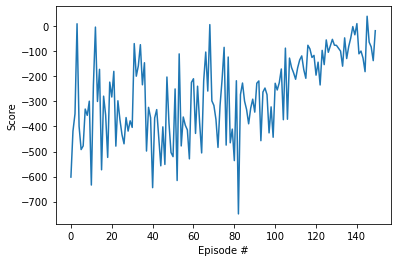

Episode 100	Average Score: -319.82
Episode 150	Average Score: -296.46Learning rate:0.0003704000000000005


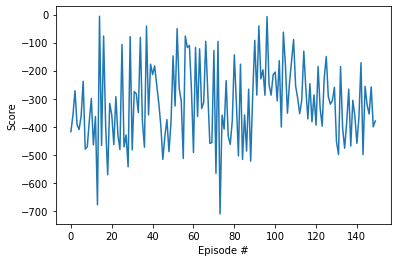

Episode 100	Average Score: -266.12
Episode 150	Average Score: -216.92Learning rate:0.0003706000000000005


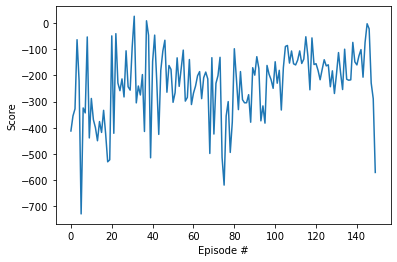

Episode 100	Average Score: -381.90
Episode 150	Average Score: -381.83Learning rate:0.0003708000000000005


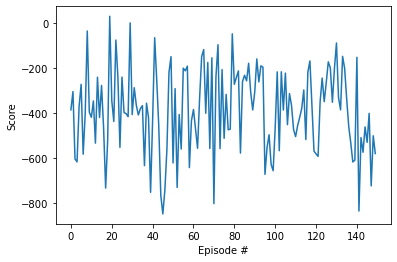

Episode 100	Average Score: -313.43
Episode 150	Average Score: -260.85Learning rate:0.0003710000000000005


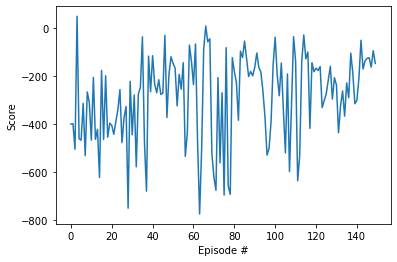

Episode 100	Average Score: -320.69
Episode 150	Average Score: -313.54Learning rate:0.0003712000000000005


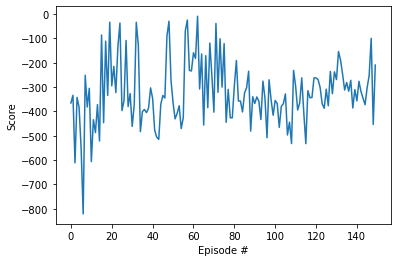

Episode 100	Average Score: -309.64
Episode 150	Average Score: -259.27Learning rate:0.0003714000000000005


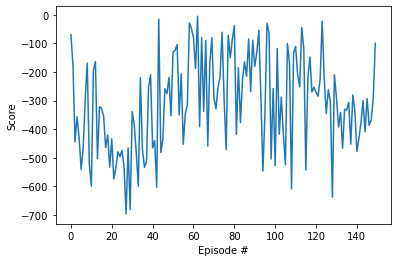

Episode 100	Average Score: -295.92
Episode 150	Average Score: -194.33Learning rate:0.0003716000000000005


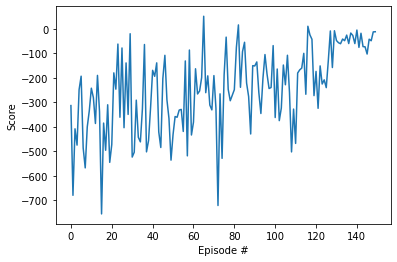

Episode 100	Average Score: -349.85
Episode 150	Average Score: -311.23Learning rate:0.0003718000000000005


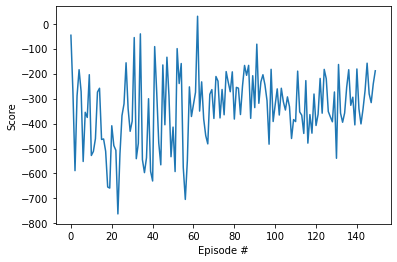

Episode 100	Average Score: -301.18
Episode 150	Average Score: -197.01Learning rate:0.00037200000000000053


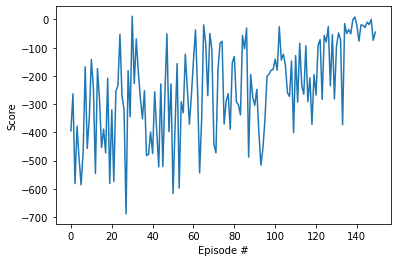

Episode 100	Average Score: -312.34
Episode 150	Average Score: -292.35Learning rate:0.00037220000000000054


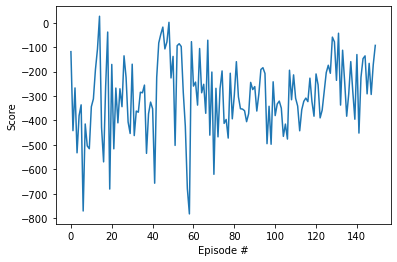

Episode 100	Average Score: -330.11
Episode 150	Average Score: -341.09Learning rate:0.00037240000000000054


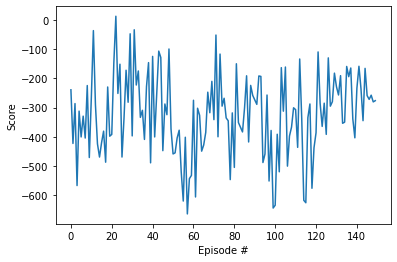

Episode 100	Average Score: -284.84
Episode 150	Average Score: -205.65Learning rate:0.00037260000000000055


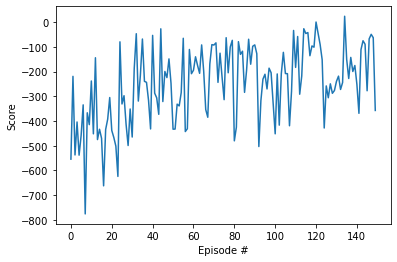

Episode 100	Average Score: -302.55
Episode 150	Average Score: -348.09Learning rate:0.00037280000000000055


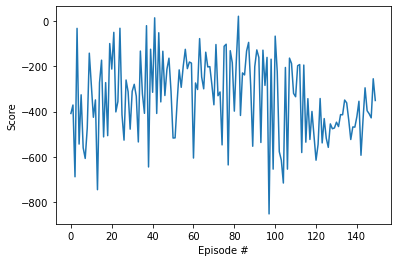

Episode 100	Average Score: -287.12
Episode 150	Average Score: -193.93Learning rate:0.00037300000000000056


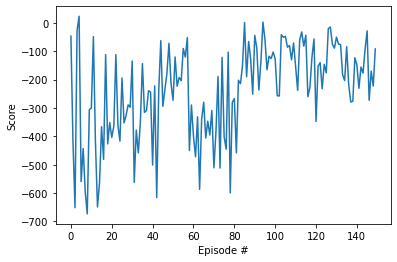

Episode 100	Average Score: -360.93
Episode 150	Average Score: -328.49Learning rate:0.00037320000000000056


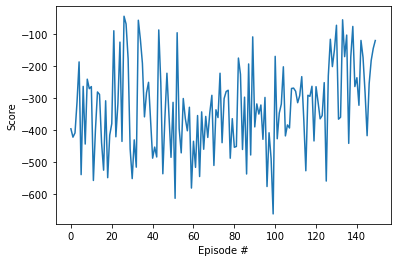

Episode 100	Average Score: -304.58
Episode 150	Average Score: -225.48Learning rate:0.00037340000000000057


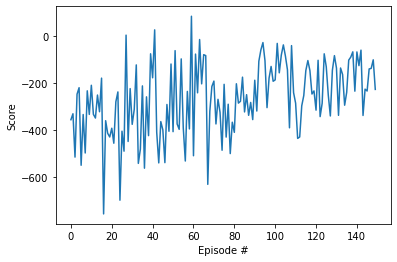

Episode 100	Average Score: -284.03
Episode 150	Average Score: -182.87Learning rate:0.00037360000000000057


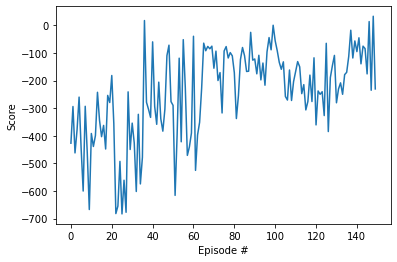

Episode 100	Average Score: -301.37
Episode 150	Average Score: -251.64Learning rate:0.0003738000000000006


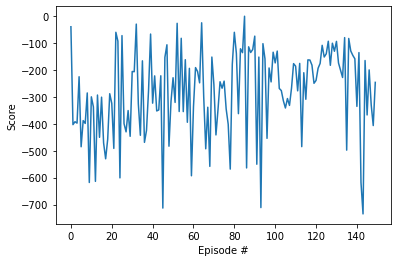

Episode 100	Average Score: -232.52
Episode 150	Average Score: -162.16Learning rate:0.0003740000000000006


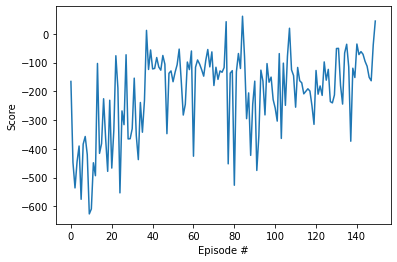

Episode 100	Average Score: -322.91
Episode 150	Average Score: -289.52Learning rate:0.0003742000000000006


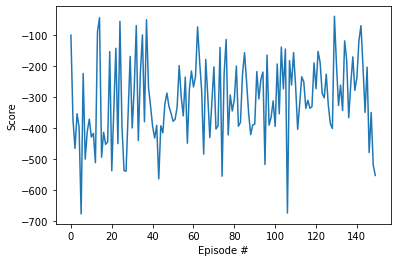

Episode 100	Average Score: -318.55
Episode 150	Average Score: -312.66Learning rate:0.0003744000000000006


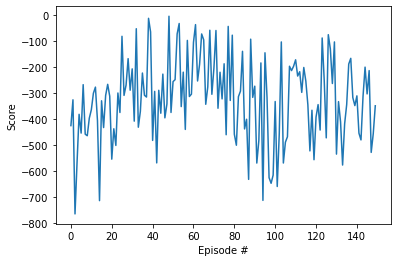

Episode 100	Average Score: -291.34
Episode 150	Average Score: -157.00Learning rate:0.0003746000000000006


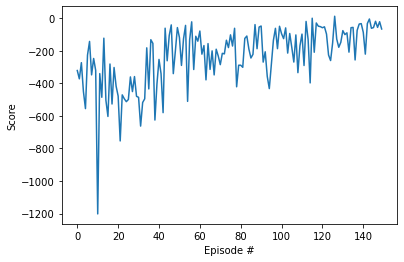

Episode 100	Average Score: -317.19
Episode 110	Average Score: -310.07

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode 100	Average Score: -275.50
Episode 150	Average Score: -175.96Learning rate:0.0003788000000000007


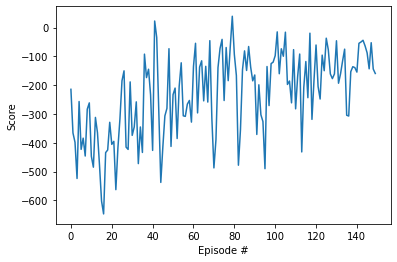

Episode 100	Average Score: -277.34
Episode 150	Average Score: -110.05Learning rate:0.0003790000000000007


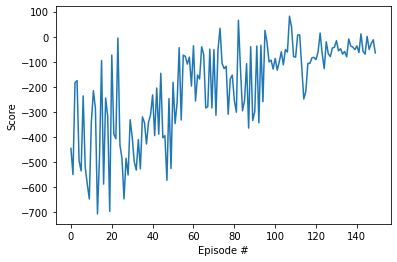

Episode 100	Average Score: -364.21
Episode 150	Average Score: -275.41Learning rate:0.0003792000000000007


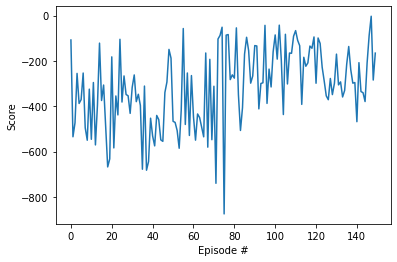

Episode 100	Average Score: -315.34
Episode 150	Average Score: -260.08Learning rate:0.0003794000000000007


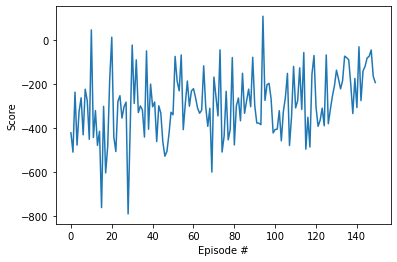

Episode 100	Average Score: -291.01
Episode 150	Average Score: -180.62Learning rate:0.0003796000000000007


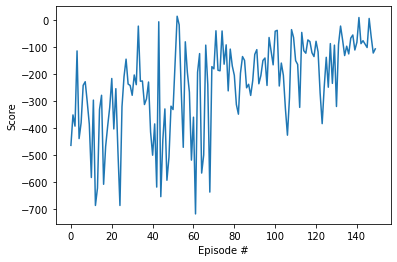

Episode 100	Average Score: -369.74
Episode 150	Average Score: -305.25Learning rate:0.0003798000000000007


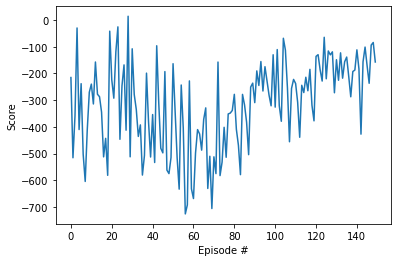

Episode 100	Average Score: -310.71
Episode 150	Average Score: -221.90Learning rate:0.0003800000000000007


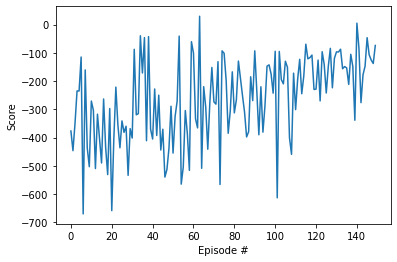

Episode 100	Average Score: -287.03
Episode 150	Average Score: -210.43Learning rate:0.00038020000000000073


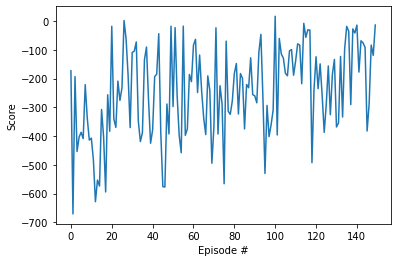

Episode 100	Average Score: -323.98
Episode 150	Average Score: -189.89Learning rate:0.00038040000000000074


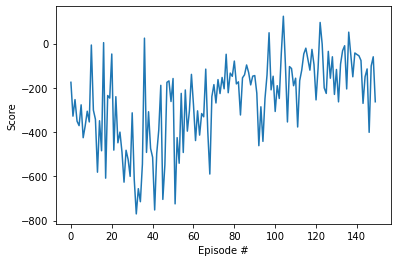

Episode 100	Average Score: -324.10
Episode 150	Average Score: -238.81Learning rate:0.00038060000000000074


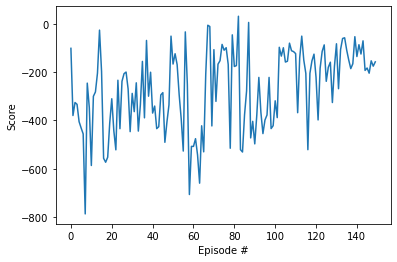

Episode 100	Average Score: -346.00
Episode 150	Average Score: -361.18Learning rate:0.00038080000000000075


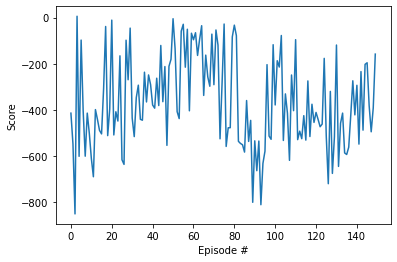

Episode 100	Average Score: -304.96
Episode 150	Average Score: -282.13Learning rate:0.00038100000000000075


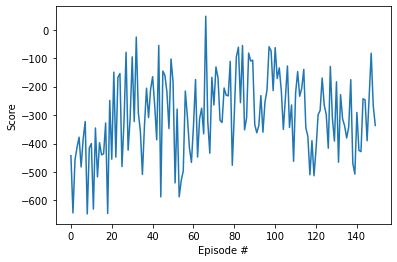

Episode 100	Average Score: -334.93
Episode 150	Average Score: -310.01Learning rate:0.00038120000000000075


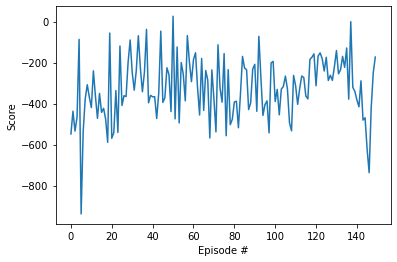

Episode 100	Average Score: -325.65
Episode 150	Average Score: -295.59Learning rate:0.00038140000000000076


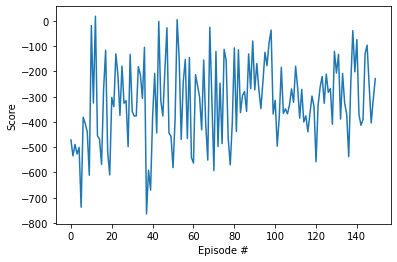

Episode 100	Average Score: -320.97
Episode 150	Average Score: -251.05Learning rate:0.00038160000000000076


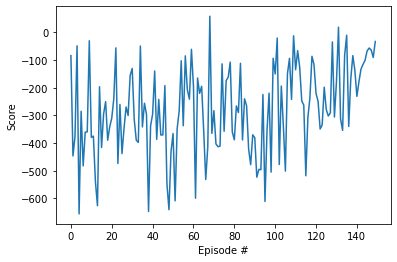

Episode 100	Average Score: -358.52
Episode 150	Average Score: -284.59Learning rate:0.00038180000000000077


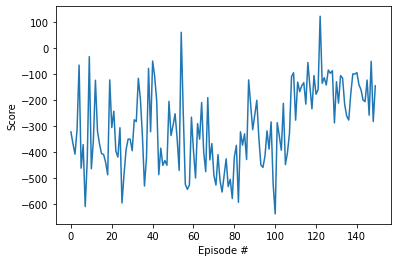

Episode 100	Average Score: -308.15
Episode 150	Average Score: -212.94Learning rate:0.0003820000000000008


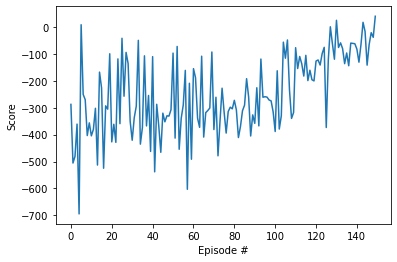

Episode 100	Average Score: -263.36
Episode 150	Average Score: -226.46Learning rate:0.0003822000000000008


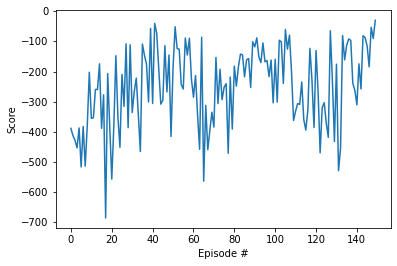

Episode 100	Average Score: -230.21
Episode 150	Average Score: -138.04Learning rate:0.0003824000000000008


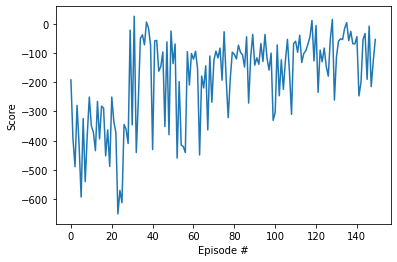

Episode 100	Average Score: -263.87
Episode 150	Average Score: -170.22Learning rate:0.0003826000000000008


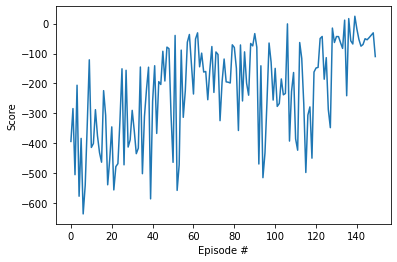

Episode 8	Average Score: -441.24

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode 150	Average Score: -329.46Learning rate:0.0003880000000000009


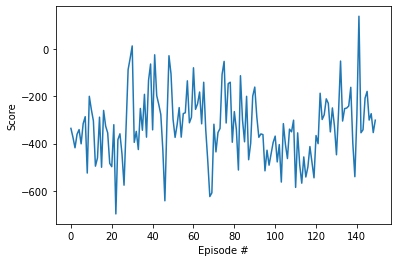

Episode 100	Average Score: -307.88
Episode 150	Average Score: -259.41Learning rate:0.0003882000000000009


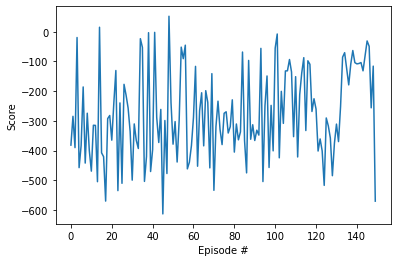

Episode 100	Average Score: -331.89
Episode 150	Average Score: -187.30Learning rate:0.00038840000000000093


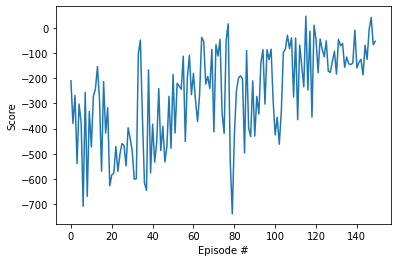

Episode 100	Average Score: -240.70
Episode 150	Average Score: -120.57Learning rate:0.00038860000000000093


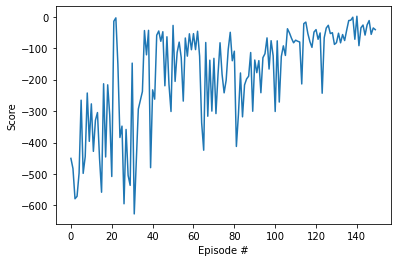

Episode 100	Average Score: -329.67
Episode 150	Average Score: -238.76Learning rate:0.00038880000000000094


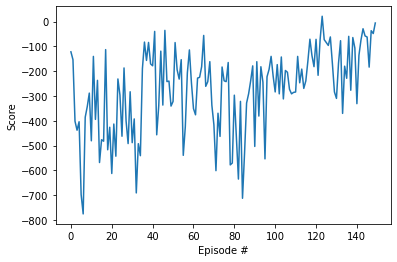

Episode 100	Average Score: -298.36
Episode 150	Average Score: -300.53Learning rate:0.00038900000000000094


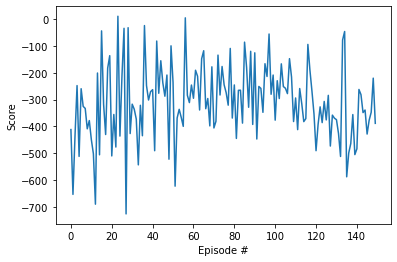

Episode 100	Average Score: -334.03
Episode 150	Average Score: -360.97Learning rate:0.00038920000000000095


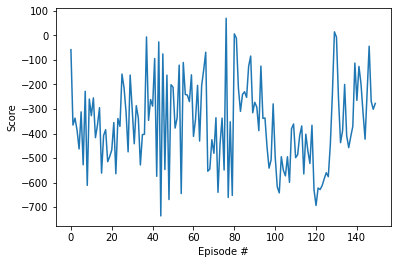

Episode 100	Average Score: -276.30
Episode 150	Average Score: -177.39Learning rate:0.00038940000000000095


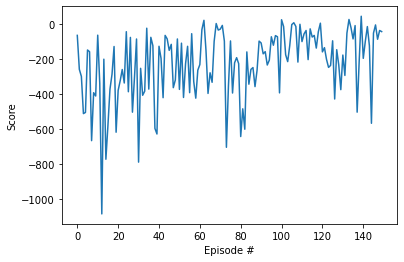

Episode 100	Average Score: -313.56
Episode 150	Average Score: -262.06Learning rate:0.00038960000000000096


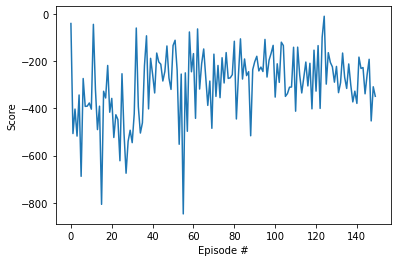

Episode 100	Average Score: -357.37
Episode 150	Average Score: -370.30Learning rate:0.00038980000000000096


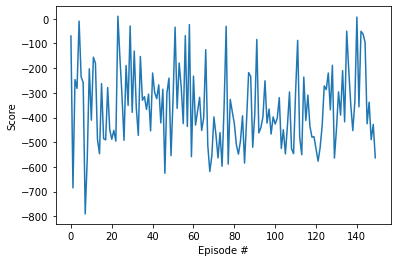

Episode 100	Average Score: -297.94
Episode 150	Average Score: -249.93Learning rate:0.00039000000000000097


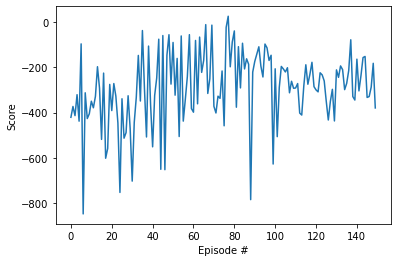

Episode 100	Average Score: -369.01
Episode 150	Average Score: -298.56Learning rate:0.000390200000000001


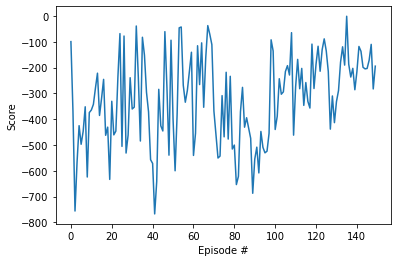

Episode 100	Average Score: -327.43
Episode 150	Average Score: -311.74Learning rate:0.000390400000000001


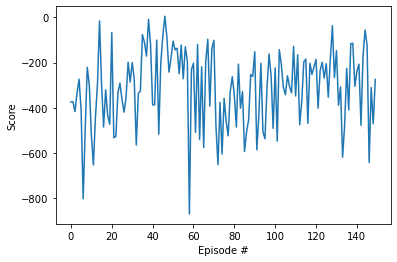

Episode 100	Average Score: -321.74
Episode 150	Average Score: -213.64Learning rate:0.000390600000000001


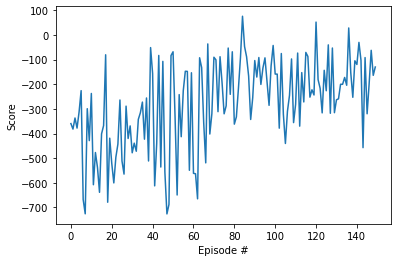

Episode 100	Average Score: -269.21
Episode 150	Average Score: -150.20Learning rate:0.000390800000000001


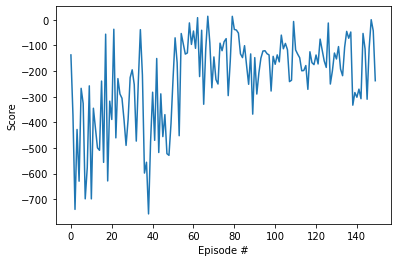

Episode 100	Average Score: -280.39
Episode 150	Average Score: -254.25Learning rate:0.000391000000000001


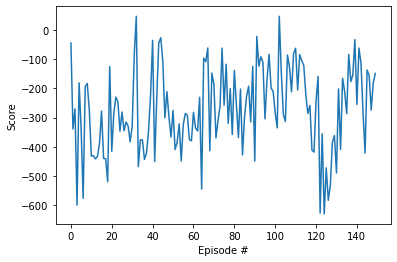

Episode 100	Average Score: -307.07
Episode 150	Average Score: -268.68Learning rate:0.000391200000000001


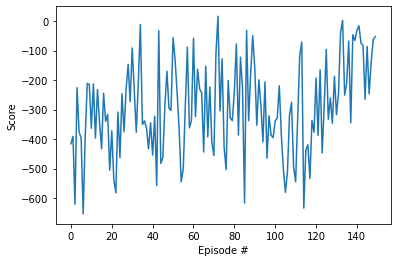

Episode 100	Average Score: -329.70
Episode 150	Average Score: -212.03Learning rate:0.000391400000000001


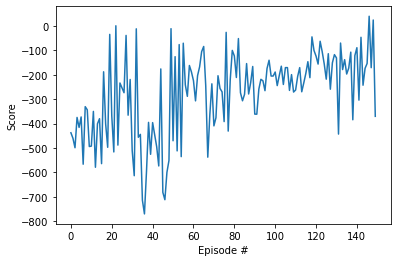

Episode 100	Average Score: -349.89
Episode 150	Average Score: -293.56Learning rate:0.000391600000000001


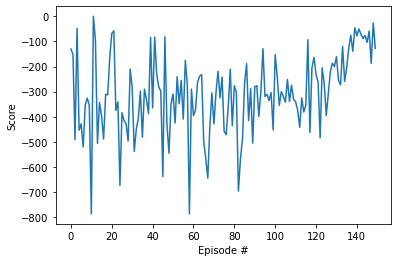

Episode 100	Average Score: -270.73
Episode 150	Average Score: -150.40Learning rate:0.000391800000000001


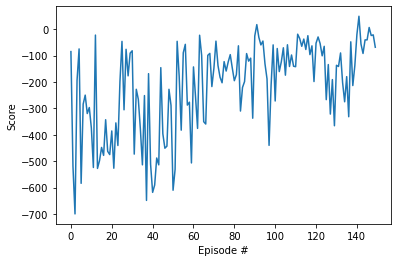

Episode 100	Average Score: -345.70
Episode 121	Average Score: -334.95

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode 100	Average Score: -334.61
Episode 150	Average Score: -293.32Learning rate:0.0003990000000000012


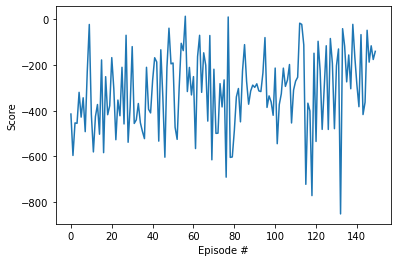

Episode 100	Average Score: -305.80
Episode 150	Average Score: -350.70Learning rate:0.0003992000000000012


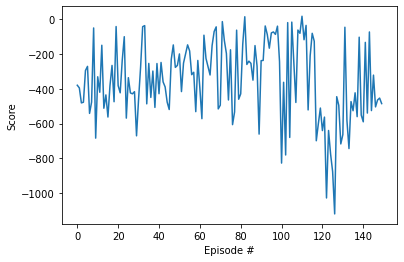

Episode 100	Average Score: -310.98
Episode 150	Average Score: -203.93Learning rate:0.0003994000000000012


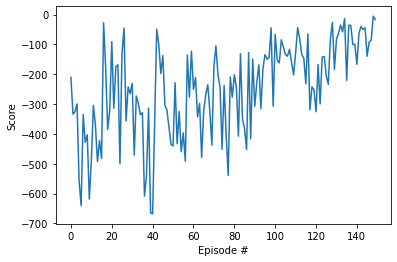

Episode 100	Average Score: -360.15
Episode 150	Average Score: -404.78Learning rate:0.0003996000000000012


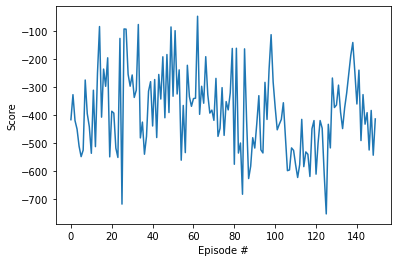

Episode 100	Average Score: -406.15
Episode 150	Average Score: -269.90Learning rate:0.0003998000000000012


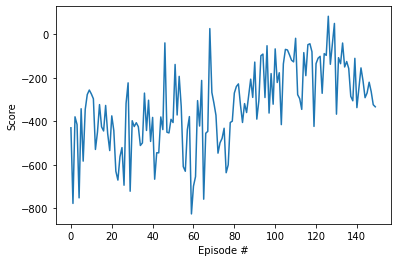

Episode 100	Average Score: -293.47
Episode 150	Average Score: -263.52Learning rate:0.0004000000000000012


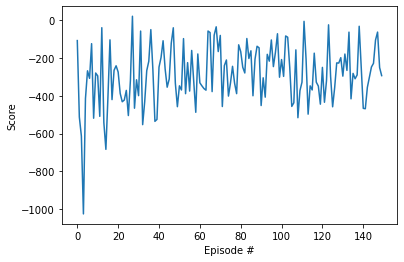

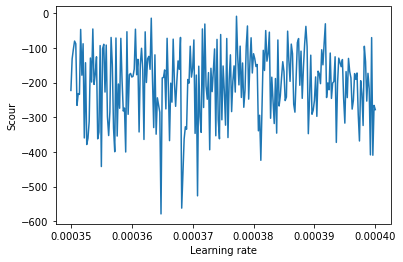

In [11]:
max_score = -999999
max_lr = -1 
running_scoures =[]
running_lr = []
for lr in np.arange(0.00000,0.0004,0.00001):#:
    agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0)
    scores = train(n_episodes=150, max_t=550)

    # plot the scores
    print(f"Learning rate:{lr}")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    socre = np.mean(scores[-10:])
    
    running_scoures.append(socre)
    running_lr.append(lr)
    if max_score < socre:
        print(f"found better LR = {lr}")
        max_score = socre
        max_lr = lr 
        
        
# plot the scores
#fig = plt.figure()
#ax = fig.add_subplot(111)
#plt.plot(running_lr, running_scoures)
#plt.xlabel('Learning rate')
#plt.ylabel('Scour')
#plt.show()
    

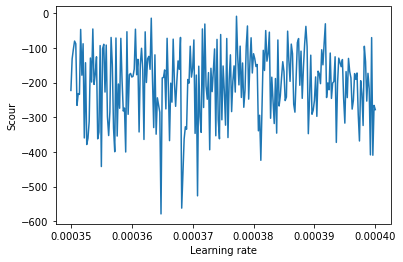

0.00037720000000000066

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(running_lr, running_scoures)
plt.xlabel('Learning rate')
plt.ylabel('Scour')
plt.show()
max_lr

# Inference and show video



Episode 100	Average Score: -340.89
Episode 200	Average Score: -292.03
Episode 300	Average Score: -103.33
Episode 400	Average Score: -91.746
Episode 500	Average Score: -17.82
Episode 600	Average Score: 65.728
Episode 700	Average Score: 51.41
Episode 800	Average Score: 22.69
Episode 900	Average Score: 97.04
Episode 1000	Average Score: 196.01
Episode 1100	Average Score: 193.21
Episode 1136	Average Score: 200.58
Environment solved in 1036 episodes!	Average Score: 200.58


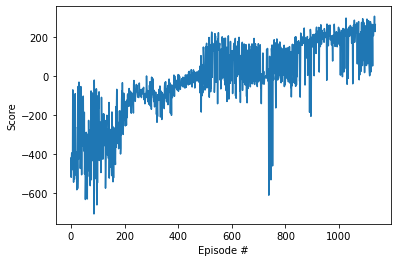

In [14]:
agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0,lr=max_lr)
scores = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env = wrap_env(env)
agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling_DDQN.pth', map_location=lambda storage, loc: storage))
sum = 0
max_steps = 3000 
running_count = 200

for i in range(running_count):
    print(f"episode {i}")
    state = env.reset()
    Total_reward = 0

    for j in range(max_steps):
        action = agent.act(state)
        action_step = actions.get_action(action)        
        state, reward, done, _ = env.step(action_step)
        Total_reward += reward
        if done:
            break 
    sum += Total_reward
avg = sum / 200
print(f"avg: {avg}")
              
env.close()
show_video()  



In [ ]:
# for j in range(max_steps):
#     action = agent.act(state)

#     action_step = actions.get_action(action)        
#     state, reward, done, _ = env.step(action_step)
#     # if i >= 199:
#     #     img.set_data(env.render(mode='rgb_array')) 
#     #     # plt.axis('off')
#     #     display.display(plt.gcf())
#     #     display.clear_output(wait=True)
#     Total_reward += reward
#     if done:
#         break 